# 0. Imports and Useful Functions from Other Notebooks

In [1]:
# !pip install git+https://github.com/NMBU-Data-Science/RENT.git

In [2]:
# !pip install --upgrade pip

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set()
df = pd.read_pickle('male_test.pkl')
dft = pd.read_pickle('male_train.pkl')
import os
import pickle
from glob import glob
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, ElasticNetCV
from datetime import datetime

In [6]:
# from RENT import RENT, stability
import time
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [7]:
def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)
    
def age_deconfounding(predicted_ages, chronological_ages):
    
    if isinstance(predicted_ages, pd.Series):
        predicted_ages = predicted_ages.to_numpy()
    
    if isinstance(chronological_ages, pd.Series):
        chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

In [8]:
# df_train = {}
# for idx in range(len(df)):
#     name = dft.iloc[idx].modality
# #     data = dft.iloc[idx].dataframe.output_age_decon.to_list()
#     data = dft.iloc[idx].dataframe.mean_output_age.to_list()
#     df_train[name] = data
    
# df_train = pd.DataFrame.from_dict(df_train)
# df_train['target_age'] = dft.iloc[0].dataframe.target_age.to_list()

In [9]:
from sklearn.model_selection import train_test_split

df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjects_testA = df_testA['Unnamed: 0'].to_list()
subjects_testB = df_testB['Unnamed: 0'].to_list()
df_testA = df_testA.drop(labels='Unnamed: 0', axis=1)
df_testB = df_testB.drop(labels='Unnamed: 0', axis=1)

df_train = df_testA
df_test = df_testB

In [10]:
df_train

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD,target_age
1588,71.148967,68.758153,61.669696,64.744407,68.486633,71.360700,61.890867,65.599383,65.690795,62.132266,...,67.909127,64.590390,69.591637,67.349990,66.998962,67.754927,67.844347,69.083805,65.371872,69.037100
935,72.722655,74.274728,73.627597,76.721025,72.708425,71.743233,77.293670,70.248365,72.634313,69.213218,...,72.908250,75.025737,73.012710,70.210583,70.535967,70.304587,69.676443,68.894653,71.443407,73.034836
1450,53.217894,54.670809,59.846333,52.477524,53.091773,59.118936,59.535689,66.382952,64.171692,65.664289,...,54.274742,55.345449,50.212408,52.080364,51.377991,51.042342,51.875048,57.676217,56.809871,56.950137
2512,74.175563,72.697128,74.099559,74.274790,76.285502,68.507303,74.087580,73.800220,74.171987,72.693825,...,74.826955,74.367054,71.739193,73.452775,72.792558,72.229397,73.131657,74.697147,73.385949,74.185731
1353,51.269549,54.316068,55.047965,52.875921,52.832307,53.800731,54.469474,58.777314,56.815188,57.829699,...,52.358435,51.214033,54.785422,54.488783,54.894757,55.669731,54.966000,51.753970,52.647824,46.675546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,68.766762,71.101570,70.367163,65.406616,69.015688,65.642769,64.954569,61.288846,64.017198,60.159990,...,71.324177,71.450927,70.124225,68.738298,69.041345,69.600773,68.669713,65.290835,68.079060,72.299863
2763,62.977201,63.566440,61.328991,62.450789,62.443869,61.490969,67.437797,60.017762,58.644575,63.557648,...,60.387687,60.071782,62.241811,64.079780,64.293267,64.175193,61.909395,64.599708,65.660425,66.124087
905,70.890430,67.332623,72.631668,66.376517,69.516073,71.266423,73.919892,70.141248,70.650945,71.114835,...,65.015291,68.461108,69.951328,73.274285,71.721979,68.954783,71.726060,70.784825,69.117790,74.020205
3980,65.784067,66.013202,68.745940,65.850317,67.242687,63.450094,67.237207,67.940033,66.493972,61.675599,...,67.027719,68.024317,66.486773,67.338935,67.296982,65.385612,65.496723,70.243285,68.312545,69.108607


# Define RENT ensemble for regression

In [9]:
train_data = df_train.loc[:, df_train.columns != 'target_age']
train_labels = df_train['target_age']

test_data = df_test.loc[:, df_test.columns != 'target_age']
test_labels = df_test['target_age']

In [10]:
feat_names = df_train.columns[:-1].to_list()
feat_names

['T1_nonlinear',
 'T1_linear',
 'jacobian',
 'vbm',
 'T2_nonlinear',
 'T2_lesions',
 'swi',
 'rsfmri_0',
 'rsfmri_1',
 'rsfmri_2',
 'rsfmri_3',
 'rsfmri_4',
 'rsfmri_5',
 'rsfmri_6',
 'rsfmri_7',
 'rsfmri_8',
 'rsfmri_9',
 'rsfmri_10',
 'rsfmri_11',
 'rsfmri_12',
 'rsfmri_13',
 'rsfmri_14',
 'rsfmri_15',
 'rsfmri_16',
 'rsfmri_17',
 'rsfmri_18',
 'rsfmri_19',
 'rsfmri_20',
 'rsfmri_21',
 'rsfmri_22',
 'rsfmri_23',
 'rsfmri_24',
 'tfmri_1',
 'tfmri_2',
 'tfmri_5',
 'tfmri_c_1',
 'tfmri_c_2',
 'tfmri_c_5',
 'tracts',
 'tbss_FA_s',
 'tbss_ICVF_s',
 'tbss_ISOVF_s',
 'tbss_L1_s',
 'tbss_L2_s',
 'tbss_L3_s',
 'tbss_MD_s',
 'tbss_MO_s',
 'tbss_OD_s',
 'tbss_FA',
 'tbss_ICVF',
 'tbss_ISOVF',
 'tbss_L1',
 'tbss_L2',
 'tbss_L3',
 'tbss_MD',
 'tbss_MO',
 'tbss_OD']

In [11]:
train_data

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_OD_s,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD
1588,71.148967,68.758153,61.669696,64.744407,68.486633,71.360700,61.890867,65.599383,65.690795,62.132266,...,67.355062,67.909127,64.590390,69.591637,67.349990,66.998962,67.754927,67.844347,69.083805,65.371872
935,72.722655,74.274728,73.627597,76.721025,72.708425,71.743233,77.293670,70.248365,72.634313,69.213218,...,74.993675,72.908250,75.025737,73.012710,70.210583,70.535967,70.304587,69.676443,68.894653,71.443407
1450,53.217894,54.670809,59.846333,52.477524,53.091773,59.118936,59.535689,66.382952,64.171692,65.664289,...,54.359653,54.274742,55.345449,50.212408,52.080364,51.377991,51.042342,51.875048,57.676217,56.809871
2512,74.175563,72.697128,74.099559,74.274790,76.285502,68.507303,74.087580,73.800220,74.171987,72.693825,...,75.334162,74.826955,74.367054,71.739193,73.452775,72.792558,72.229397,73.131657,74.697147,73.385949
1353,51.269549,54.316068,55.047965,52.875921,52.832307,53.800731,54.469474,58.777314,56.815188,57.829699,...,54.829236,52.358435,51.214033,54.785422,54.488783,54.894757,55.669731,54.966000,51.753970,52.647824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,68.766762,71.101570,70.367163,65.406616,69.015688,65.642769,64.954569,61.288846,64.017198,60.159990,...,66.672675,71.324177,71.450927,70.124225,68.738298,69.041345,69.600773,68.669713,65.290835,68.079060
2763,62.977201,63.566440,61.328991,62.450789,62.443869,61.490969,67.437797,60.017762,58.644575,63.557648,...,67.775967,60.387687,60.071782,62.241811,64.079780,64.293267,64.175193,61.909395,64.599708,65.660425
905,70.890430,67.332623,72.631668,66.376517,69.516073,71.266423,73.919892,70.141248,70.650945,71.114835,...,70.847585,65.015291,68.461108,69.951328,73.274285,71.721979,68.954783,71.726060,70.784825,69.117790
3980,65.784067,66.013202,68.745940,65.850317,67.242687,63.450094,67.237207,67.940033,66.493972,61.675599,...,71.008145,67.027719,68.024317,66.486773,67.338935,67.296982,65.385612,65.496723,70.243285,68.312545


In [12]:
train_labels.head()

1588    69.037100
935     73.034836
1450    56.950137
2512    74.185731
1353    46.675546
Name: target_age, dtype: float64

In [13]:
train_data.loc[[8]]

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_OD_s,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD
8,69.982063,69.340002,64.941247,70.00922,69.690247,68.447024,69.223846,60.437354,63.586167,66.453997,...,64.481566,68.609627,69.438147,67.279653,64.238108,66.71315,66.768557,66.113531,65.373317,65.210753


In [14]:
new_idxs = np.arange(0,train_data.shape[0],1)
train_data.index = list(new_idxs)
train_data

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_OD_s,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD
0,71.148967,68.758153,61.669696,64.744407,68.486633,71.360700,61.890867,65.599383,65.690795,62.132266,...,67.355062,67.909127,64.590390,69.591637,67.349990,66.998962,67.754927,67.844347,69.083805,65.371872
1,72.722655,74.274728,73.627597,76.721025,72.708425,71.743233,77.293670,70.248365,72.634313,69.213218,...,74.993675,72.908250,75.025737,73.012710,70.210583,70.535967,70.304587,69.676443,68.894653,71.443407
2,53.217894,54.670809,59.846333,52.477524,53.091773,59.118936,59.535689,66.382952,64.171692,65.664289,...,54.359653,54.274742,55.345449,50.212408,52.080364,51.377991,51.042342,51.875048,57.676217,56.809871
3,74.175563,72.697128,74.099559,74.274790,76.285502,68.507303,74.087580,73.800220,74.171987,72.693825,...,75.334162,74.826955,74.367054,71.739193,73.452775,72.792558,72.229397,73.131657,74.697147,73.385949
4,51.269549,54.316068,55.047965,52.875921,52.832307,53.800731,54.469474,58.777314,56.815188,57.829699,...,54.829236,52.358435,51.214033,54.785422,54.488783,54.894757,55.669731,54.966000,51.753970,52.647824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,68.766762,71.101570,70.367163,65.406616,69.015688,65.642769,64.954569,61.288846,64.017198,60.159990,...,66.672675,71.324177,71.450927,70.124225,68.738298,69.041345,69.600773,68.669713,65.290835,68.079060
2178,62.977201,63.566440,61.328991,62.450789,62.443869,61.490969,67.437797,60.017762,58.644575,63.557648,...,67.775967,60.387687,60.071782,62.241811,64.079780,64.293267,64.175193,61.909395,64.599708,65.660425
2179,70.890430,67.332623,72.631668,66.376517,69.516073,71.266423,73.919892,70.141248,70.650945,71.114835,...,70.847585,65.015291,68.461108,69.951328,73.274285,71.721979,68.954783,71.726060,70.784825,69.117790
2180,65.784067,66.013202,68.745940,65.850317,67.242687,63.450094,67.237207,67.940033,66.493972,61.675599,...,71.008145,67.027719,68.024317,66.486773,67.338935,67.296982,65.385612,65.496723,70.243285,68.312545


In [15]:
my_C_params = [0.1, 1, 10]
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

model = RENT.RENT_Regression(data=train_data, 
                                target=train_labels, 
                                feat_names=train_data.columns.to_list(), 
                                C= my_C_params, 
                                l1_ratios=my_l1_ratios,
                                autoEnetParSel=True,
#                                 autoEnetParSel=False,
                                poly='OFF',
                                testsize_range=(0.25,0.25),
                                K=100,
                                random_state=0,
                                verbose=1)

data dimension: (2182, 57)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (2182,)
regularization parameters C: [0.1, 1, 10]
elastic net l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1


## A deeper insight into RENT hyperparameter selection with cross-validation

In [16]:
cv_score, cv_zeros, cv_harmonic_mean = model.get_cv_matrices()

In [17]:
cv_harmonic_mean

Harmonic Mean,0.1,1.0,10.0
0.00,0.000000,0.000000,0.000000
0.10,0.006424,0.482416,0.272132
0.25,0.572954,0.570968,0.379118
0.50,0.797101,0.649684,0.772229
0.75,NaN,0.774698,0.919204
0.90,NaN,0.894250,0.920246
1.00,NaN,0.942591,0.923973


## Train RENT ensemble and inspect results

In [18]:
model.train()

In [19]:
model.get_runtime()

1.4825999736785889

In [20]:
model.get_enet_params()

(1.0, 1.0)

## Set selection criteria cutoffs

In [21]:
selected_features = model.select_features(tau_1_cutoff=0.9, tau_2_cutoff=0.9, tau_3_cutoff=0.975)

In [22]:
selected_features

array([ 0,  1,  4, 48, 56])

In [23]:
train_data.columns[selected_features]

Index(['T1_nonlinear', 'T1_linear', 'T2_nonlinear', 'tbss_FA', 'tbss_OD'], dtype='object')

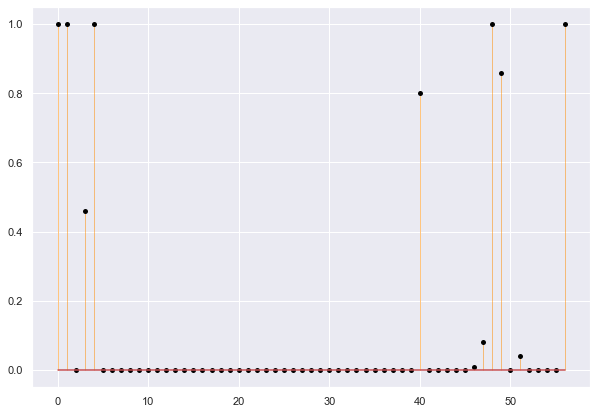

In [24]:
model.plot_selection_frequency()

In [25]:
weight_dist = model.get_weight_distributions(binary=False)
weight_dist

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_OD_s,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD
mod 1,1.695754,0.795667,0.0,0.000000,2.874262,0.0,0.0,0.0,0.0,0.0,...,0.0,0.543447,0.050216,0.0,0.0,0.0,0.0,0.0,0.0,0.245961
mod 2,1.480488,0.721622,0.0,0.000000,3.166260,0.0,0.0,0.0,0.0,0.0,...,0.0,0.483745,0.259953,0.0,0.0,0.0,0.0,0.0,0.0,0.114743
mod 3,1.944595,0.672187,0.0,0.227892,2.718730,0.0,0.0,0.0,0.0,0.0,...,0.0,0.246039,0.176548,0.0,0.0,0.0,0.0,0.0,0.0,0.214935
mod 4,1.582843,0.701767,0.0,0.120146,2.899331,0.0,0.0,0.0,0.0,0.0,...,0.0,0.705605,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.132958
mod 5,1.527826,0.877259,0.0,0.000000,2.848956,0.0,0.0,0.0,0.0,0.0,...,0.0,0.583263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.253794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mod 96,1.860220,0.801331,0.0,0.069356,2.684817,0.0,0.0,0.0,0.0,0.0,...,0.0,0.514026,0.010912,0.0,0.0,0.0,0.0,0.0,0.0,0.163237
mod 97,1.756424,0.656251,0.0,0.056852,2.721680,0.0,0.0,0.0,0.0,0.0,...,0.0,0.622540,0.189328,0.0,0.0,0.0,0.0,0.0,0.0,0.113233
mod 98,2.004285,0.596133,0.0,0.000000,2.723450,0.0,0.0,0.0,0.0,0.0,...,0.0,0.594259,0.078733,0.0,0.0,0.0,0.0,0.0,0.0,0.193460
mod 99,1.670200,0.787112,0.0,0.000000,2.767492,0.0,0.0,0.0,0.0,0.0,...,0.0,0.416056,0.326867,0.0,0.0,0.0,0.0,0.0,0.0,0.232348


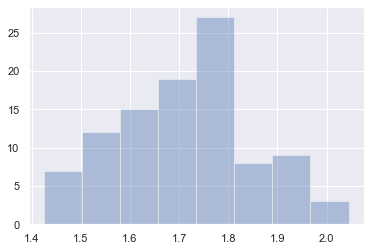

In [26]:
ax = sns.distplot(weight_dist.values[:, 0], kde=False)

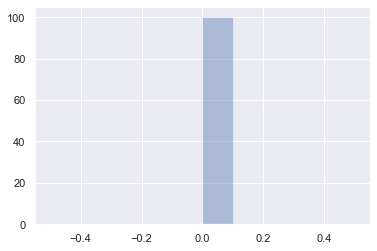

In [27]:
ax = sns.distplot(weight_dist.values[:, 23], kde=False)

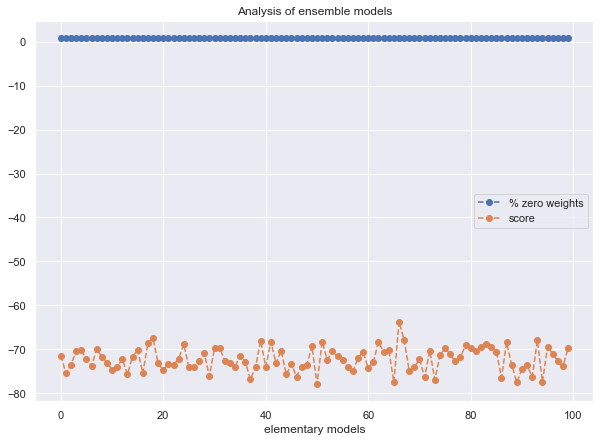

In [28]:
model.plot_elementary_models()

## Check performance using only selected features

### Linear Regression

In [29]:
# Scale the data accordingly
# sc = StandardScaler()
# train_data_1 = sc.fit_transform(train_data.iloc[:, selected_features])
# test_data_1 = sc.transform(test_data.iloc[:, selected_features])
train = train_data.values[:,selected_features]
test = test_data.values[:,selected_features]

# Train model with 
prediction_model = LinearRegression().fit(train, train_labels)

# Print results
print("R2: ", r2_score(test_labels, prediction_model.predict(test)))
print("RMSEP: ", np.sqrt(mean_squared_error(test_labels, prediction_model.predict(test))))

R2:  0.8689890189963994
RMSEP:  2.7402910181773636


In [30]:
test_outputs = prediction_model.predict(test)
test_outputs_decon = age_deconfounding(test_outputs, test_labels)
Age_Deltas_decon = test_outputs_decon - test_labels

In [31]:
print("MAE Decon:", np.abs(Age_Deltas_decon).mean())

MAE Decon: 2.314346825794601


### ElasticNet with CV

In [32]:
train = train_data.values[:,selected_features]
test = test_data.values[:,selected_features]

# Train model with 
prediction_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(train, train_labels)

# Print results
print("R2: ", r2_score(test_labels, prediction_model.predict(test)))
print("RMSEP: ", np.sqrt(mean_squared_error(test_labels, prediction_model.predict(test))))

R2:  0.868982592278939
RMSEP:  2.7403582295669224


In [33]:
test_outputs = prediction_model.predict(test)
test_outputs_decon = age_deconfounding(test_outputs, test_labels)
Age_Deltas_decon = test_outputs_decon - test_labels

In [34]:
print("MAE Decon:", np.abs(Age_Deltas_decon).mean())


### TO DO-  ADD IN HERE A MAP TO SHOP THE WEIGHTS FOR THE SELECTED FEATURES!

MAE Decon: 2.3141653248202005


In [35]:
df_output = pd.DataFrame.from_dict({
    'modality': 'RENT',
    'dataframe': [pd.DataFrame.from_dict({
                'Unnamed: 0': subjects_testB,
                'age_delta_decon': Age_Deltas_decon
                })]
})

output_name = 'male_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        pass
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon 0 2284...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon 0 2284...
0,ElasticNetFull,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster1,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster2,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster3,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster4,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster5,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster6,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster7,Unnamed: 0 age_delta_decon 0 2284...


## Validation study regarding the features selected by RENT

mean VS1 0.7963194546215325
VS1: p-value for average score from random feature drawing:  1.5005844958493914e-24
VS1: heuristic p-value (how many scores are higher than the RENT score):  0.0
With a significancelevel of  0.05  H0 is rejected.
 
-----------------------------------------------------------
 
Mean VS2 -0.8648725218469895
VS2: p-value for average score from permutation of test labels:  0.0
VS2: heuristic p-value (how many scores are higher than the RENT score):  0.0
With a significancelevel of  0.05  H0 is rejected.


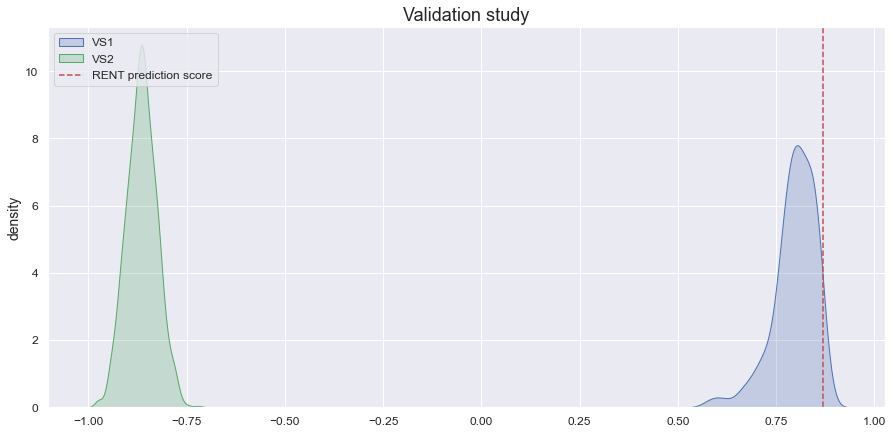

In [36]:
model.plot_validation_study(test_data, test_labels, num_drawings=100, num_permutations=1000, alpha=0.05)

loo


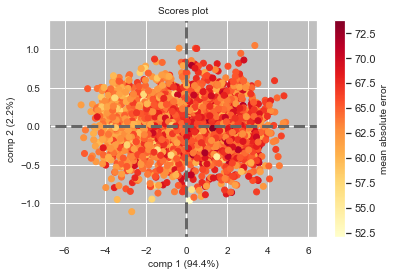

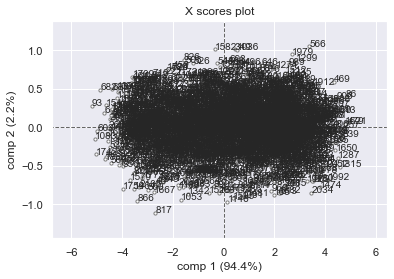

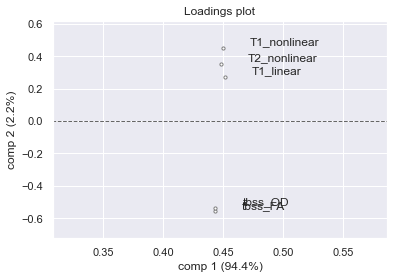

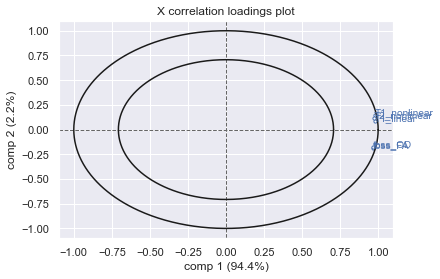

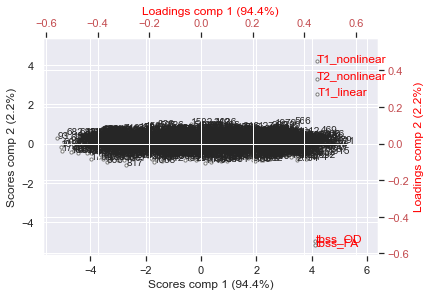

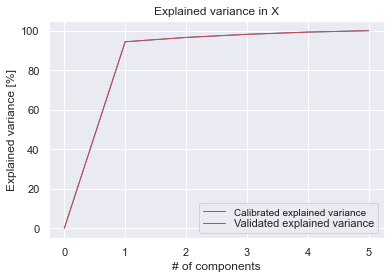

In [37]:
model.get_summary_objects()
model.plot_object_PCA(cl='continuous', problem="regression")

# Stability analysis of RENT

In [38]:
M=10 # number of runs 
alpha = 0.05 # level of significance for the confidence interval 
d = len(train_data.columns) # number of features
counts = [2, 5, 10, 50, 100, 300, 500] # values to compare (K)
C, l1 = model.get_enet_params()

# Store outputs in dictionaries
times = {}
stabilities = {}
perf = {}
num_feats = {}

start = time.time()

for count in counts:
    time_count = []
    Z_net = np.zeros((M,d), dtype=np.int8)
    performance = np.zeros(M)
    numFeatures = np.zeros(M)
    
    for i in range(M):
        model = RENT.RENT_Regression(data=train_data, 
                                target=train_labels, 
                                feat_names=train_data.columns, 
                                C= my_C_params, 
                                l1_ratios=my_l1_ratios,
                                autoEnetParSel=True,
                                poly='OFF',
                                testsize_range=(0.25,0.25),
                                K=count,
                                random_state=None,
                                verbose=0)
        model.train()
        features = model.select_features(0.9,0.9,0.975)
        time_count.append(model.get_runtime())
        
        #prediction model
#         sc = StandardScaler()
#         train = sc.fit_transform(train_data.values[:,features])
#         test = sc.transform(test_data.values[:,features])
        train = train_data.values[:,features]
        test = test_data.values[:,features]
        ML_model =LinearRegression().fit(train, train_labels)
        performance[i] = r2_score(test_labels, ML_model.predict(test))
        Z_net[i,features] = 1
        numFeatures[i] = len(features)
    
    times[count] = time_count
    stabilities[count] = stability.confidenceIntervals(Z_net, alpha=alpha)
    perf[count] = performance
    num_feats[count] = numFeatures    

end = time.time()

print('Runtime: ', end - start)

Runtime:  823.1243100166321


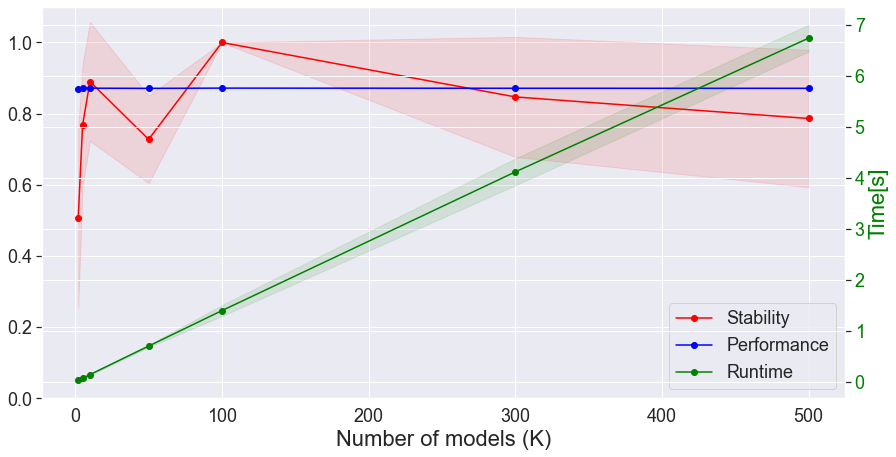

In [49]:
def stability_plot(x_levels, stabilities, accuracies, times):

    title_font_size=22
    ticks_font_size=18
    legend_font = 18
    figsize = (14.4, 7.2)
    
    stability = np.array(list({k: v['stability'] for k, v in stabilities.items()}.values()))
    stab_error = stability - np.array(list({k: v['lower'] for k, v in stabilities.items()}.values()))
    performance = np.array(list({k: np.mean(v) for k, v in accuracies.items()}.values()))
    performance_error = np.array(list({k: np.std(v) for k, v in accuracies.items()}.values()))
    runtime = np.array(list({k: np.mean(v) for k, v in times.items()}.values()))
    runtime_errors = np.array(list({k: np.std(v) for k, v in times.items()}.values())) 

    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.set_xlabel('Number of models (K)', fontsize=title_font_size)
    stab = ax1.plot(x_levels,stability, color="red", label='Stability', marker='o')
    ax1.fill_between(x_levels, (stability-stab_error), (stability+stab_error),color="red", alpha=0.1 )
    perf = ax1.plot(x_levels,performance, color="blue", label='Performance', marker='o')
    ax1.fill_between(x_levels, (performance-performance_error), (performance+performance_error),color="blue", alpha= 0.1 )
    plt.ylim(0,1.1)
    plt.yticks(fontsize=ticks_font_size)
    plt.xticks(fontsize=ticks_font_size)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time[s]', color='green',  fontsize=title_font_size)
    tim = ax2.plot(x_levels,runtime, color="green", label='Runtime', marker='o')
    ax2.fill_between(x_levels, (runtime-runtime_errors), (runtime+runtime_errors), color="green", alpha=0.1)
    ax2.tick_params(axis='y', labelcolor="green")

    leg = stab + perf + tim
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, loc=4, fontsize=legend_font)
    plt.xticks(fontsize=ticks_font_size)
    plt.yticks(fontsize=ticks_font_size)
    
    plt.savefig('Male_RENT_stability_analysis.png', bbox_inches='tight', facecolor='white')


stability_plot(counts, stabilities, perf, times)

In [11]:
def ElasticNet_wrap(df_train, df_test, cross_validation_flag = False, 
                    modalities = None, number_of_modalities=None, 
                    show_plots=False, verbose=False, fix_alpha_one=False, deconfound=False):
    
    Xtrain = []
    Ytrain = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtrain.append(np.array(df_train[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                print(col)
                Xtrain.append(np.array(df_train[col].to_list()))
    else:
        for modality in modalities:
            Xtrain.append(np.array(df_train[modality].to_list()))

    Xtrain = np.array(Xtrain)
    Ytrain = np.array(df_train['target_age'].to_list())

    if cross_validation_flag == True:
#         l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
#         model = ElasticNetCV(l1_ratio=l1_ratio,
# #                              n_alphas=n_alphas
#                             )
            l1_ratio = [0.01, 
                    .1, .11, .12, 0.13, 0.14, .15, .16, 0.17, 0.18, .19,
                    .2, .21, .22, 0.23, 0.24, .25, .26, 0.27, 0.28, .29,
                    0.3, 0.4, 
                    .5, .51, .52, 0.53, 0.54, .55, .56, 0.57, 0.58, .59,
                    .6, .61, .62, 0.63, 0.64, .65, .66, 0.67, 0.68, .69,
                    .7, .71, .72, 0.73, 0.74, .75, .76, 0.77, 0.78, .79,
                     0.8, .9, .91, .92, 0.93, 0.94, .95, .96, 0.97, 0.98, .99, 1.0]
            n_alphas = 1000
            model = ElasticNetCV(l1_ratio=l1_ratio,
                                 n_alphas=n_alphas
                                )
    else:
        model = ElasticNet(alpha=0.14766659013829683, l1_ratio=1.0)

    start_time = datetime.now()
        
    reg = model.fit(Xtrain.T, Ytrain)
    
    end_time = datetime.now()
    
    
    coefficients = reg.coef_
    intercept = reg.intercept_
     
    Xtest = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtest.append(np.array(df_test[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                Xtest.append(np.array(df_test[col].to_list()))
    else:
        for modality in modalities:
            Xtest.append(np.array(df_test[modality].to_list()))
        
    Xtest = np.array(Xtest)
    Ytest = np.array(df_test['target_age'].to_list())

    Yhat = reg.predict(Xtest.T)
    Age_Deltas = Yhat - Ytest
    
    if deconfound == True:
        Yhat_decon = age_deconfounding(Yhat, Ytest)
        Age_Deltas_decon = Yhat_decon - Ytest
    else:
        Yhat_decon = None
        Age_Deltas_decon = None
    
    mae = np.abs(Age_Deltas).mean()
    pr = pearsonr(Ytest, Yhat)[0]
    
    if deconfound == True:
        mae_decon = np.abs(Age_Deltas_decon).mean()
        pr_decon = pearsonr(Ytest, Yhat_decon)[0]
    else:
        mae_decon = None
        pr_decon = None
    
    if verbose == True:
        print('MAE=', mae)
        print('PR=', pr)
        print('Time To Complete: {}'.format(end_time - start_time))
        if deconfound == True:
            print('MAE Decon=', mae_decon)
            print('PR Decon=', pr_decon)
    
    if show_plots == True:
        scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
                               ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

        scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                               equality_line=False)

        kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)
        
        if deconfound == True:
            scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

            scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                                   equality_line=False)

            kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            
    
    if deconfound == True:
        return (reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon,
                Age_Deltas_decon,  Yhat, Age_Deltas)
    else:
        return (reg, coefficients, intercept, mae, pr, Xtrain, Ytrain, Xtest, Ytest, Yhat, Age_Deltas)

In [12]:
modalities = ['T1_nonlinear', 'T1_linear', 'T2_nonlinear', 'tbss_FA', 'tbss_OD']

In [54]:
x = ElasticNet_wrap(df_train, df_test, modalities=modalities, 
               number_of_modalities=None, show_plots=False, verbose=False,
               cross_validation_flag = True, deconfound=True)

cluster_name = 'Cluster' + str(idx)

df_output = pd.DataFrame.from_dict({
    'modality': 'RENT',
    'dataframe': [pd.DataFrame.from_dict({
                        'Unnamed: 0': subjects_testB,
                        'age_delta_decon': x[10],
                        'mean_age_delta': x[12],
                        'target_age': df_testB.target_age.values,
                        'mean_output_age': x[11]
                        })]
        })


In [55]:
output_name = 'male_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        pass
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon mean_age_de...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon mean_age_de...
0,ElasticNetFull,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster1,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster2,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster3,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster4,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster5,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster6,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster7,Unnamed: 0 age_delta_decon mean_age_de...


In [42]:
x = ElasticNet_wrap(df_train, df_test, modalities=modalities, 
               number_of_modalities=None, show_plots=False, verbose=False,
               cross_validation_flag = True, deconfound=True)

cluster_name = 'Cluster' + str(idx)

df_output = pd.DataFrame.from_dict({
    'modality': 'RENT',
    'dataframe': [pd.DataFrame.from_dict({
            'Unnamed: 0': subjects_testB,
            'age_delta_decon': x[10]
            })]
    })

# output_name = 'male_ensembles_testset.pkl'

# if os.path.exists(output_name):
#     df_ensambles = pd.read_pickle(output_name)
#     if df_output.iloc[0].modality in df_ensambles.modality.to_list():
#         pass
#     else:
#         df_ensambles = pd.concat([df_ensambles, df_output])
#         df_ensambles.to_pickle(output_name, protocol = 4)
# else:
#     df_output.to_pickle(output_name, protocol = 4)
    
# df_ensambles = pd.read_pickle(output_name)
# df_ensambles

In [43]:
x[3]

2.313739287853127

In [44]:
x[3]

2.313739287853127

In [45]:
abs(df_output.iloc[0].dataframe.age_delta_decon).mean()

2.313739287853127

In [46]:
abs(df_ensambles.iloc[-1].dataframe.age_delta_decon).mean()

2.341163392267148

MAE= 2.162055563281739
PR= 0.9322138671744258
Time To Complete: 0:00:31.001195
MAE Decon= 2.313739287853127
PR Decon= 0.9322138671744259


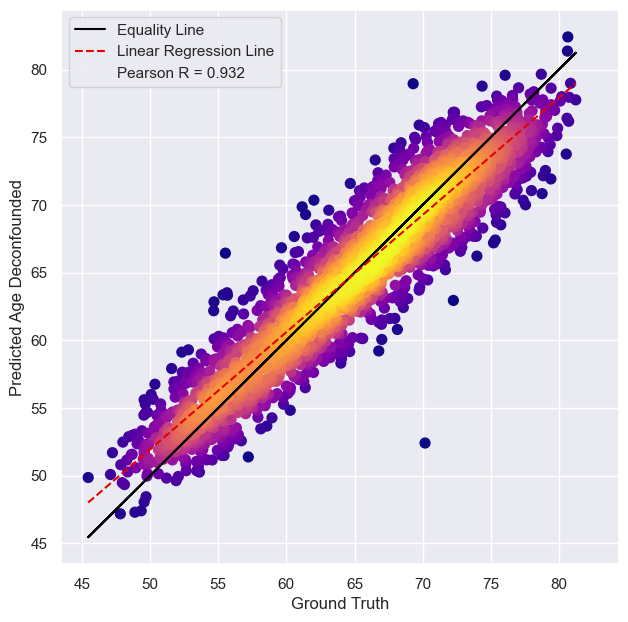

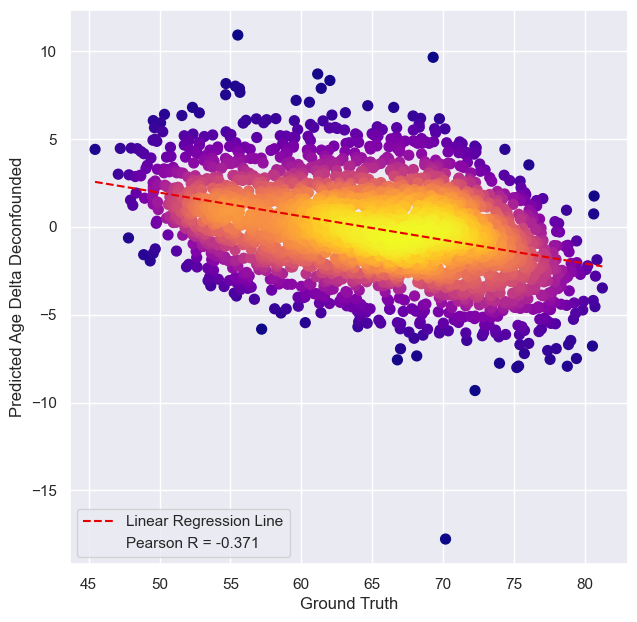

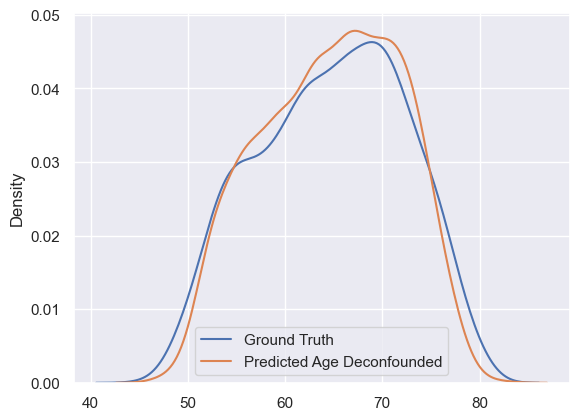

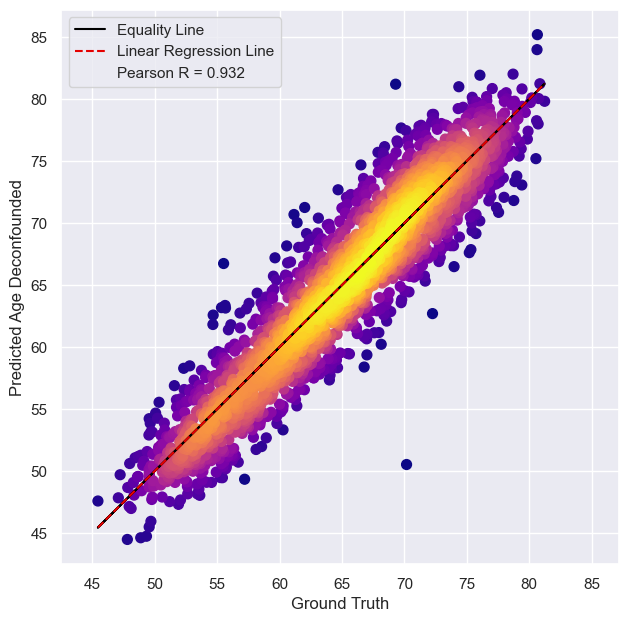

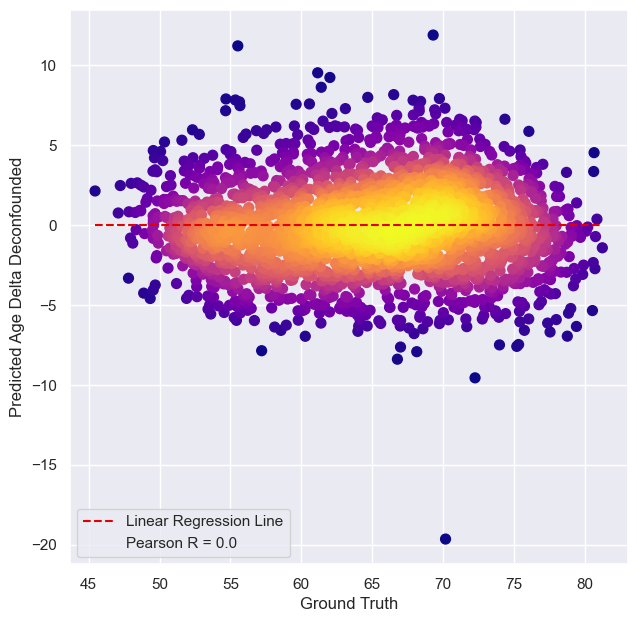

1.060885426007214
-3.907423889644292
0.22986664153127648 0.21


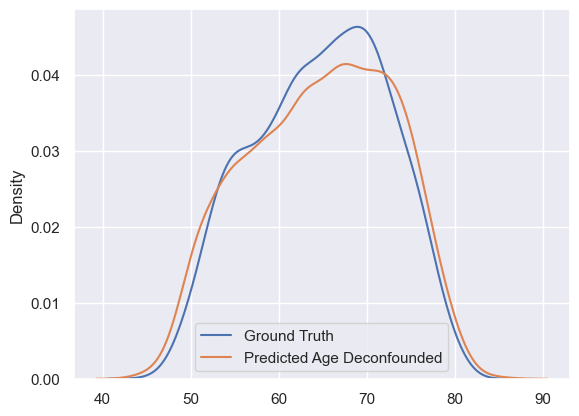

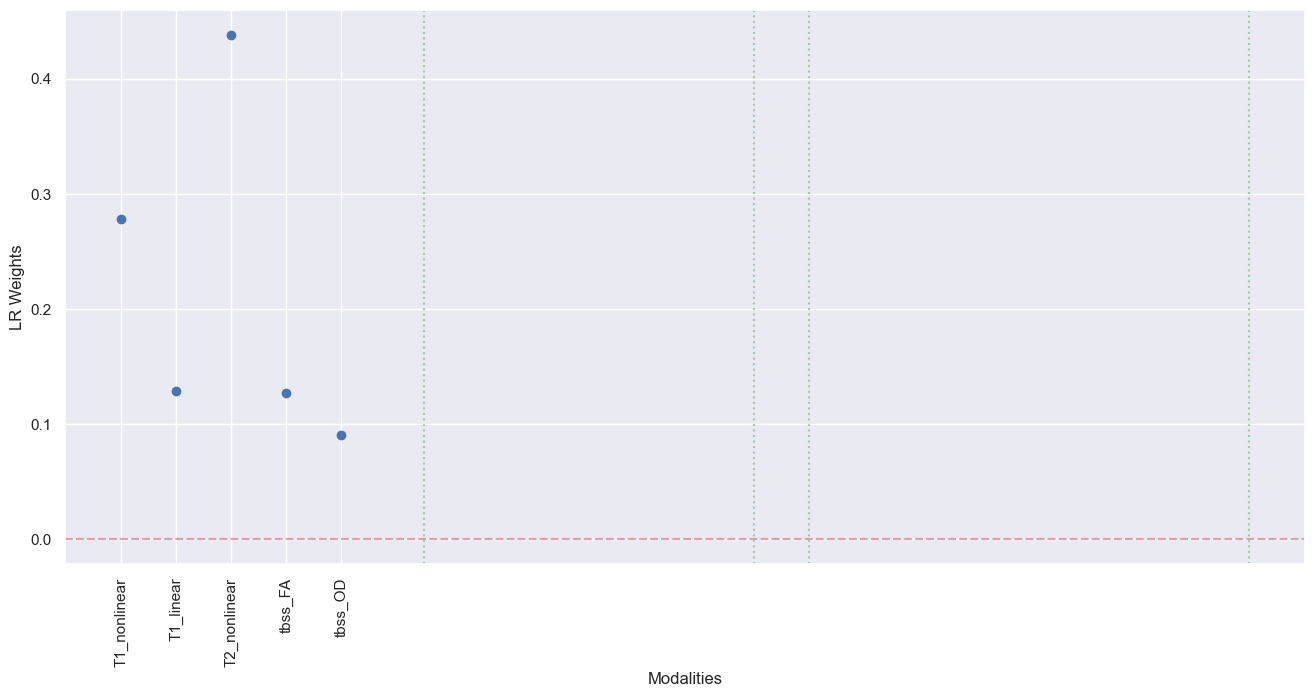

In [13]:
reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon, _, _ = ElasticNet_wrap(
                    df_train, df_test, modalities = modalities, number_of_modalities=None, show_plots=True, verbose=True, 
                    cross_validation_flag = True, fix_alpha_one=False, deconfound=True)

plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), modalities, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=5.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=11.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=12.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=20.5, color='g', linestyle='dotted', alpha=0.5);
print(coefficients.sum())
print(reg.intercept_)
print(reg.alpha_, reg.l1_ratio_)

In [48]:
output_name = 'male_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        df_ensambles.iloc[np.where(df_ensambles.modality.to_numpy()=='RENT')[0][0]].dataframe = df_output.dataframe[0]
        df_ensambles.to_pickle(output_name, protocol = 4)
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon 0 2284...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon 0 2284...
0,ElasticNetFull,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster1,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster2,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster3,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster4,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster5,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster6,Unnamed: 0 age_delta_decon 0 2284...
0,Cluster7,Unnamed: 0 age_delta_decon 0 2284...


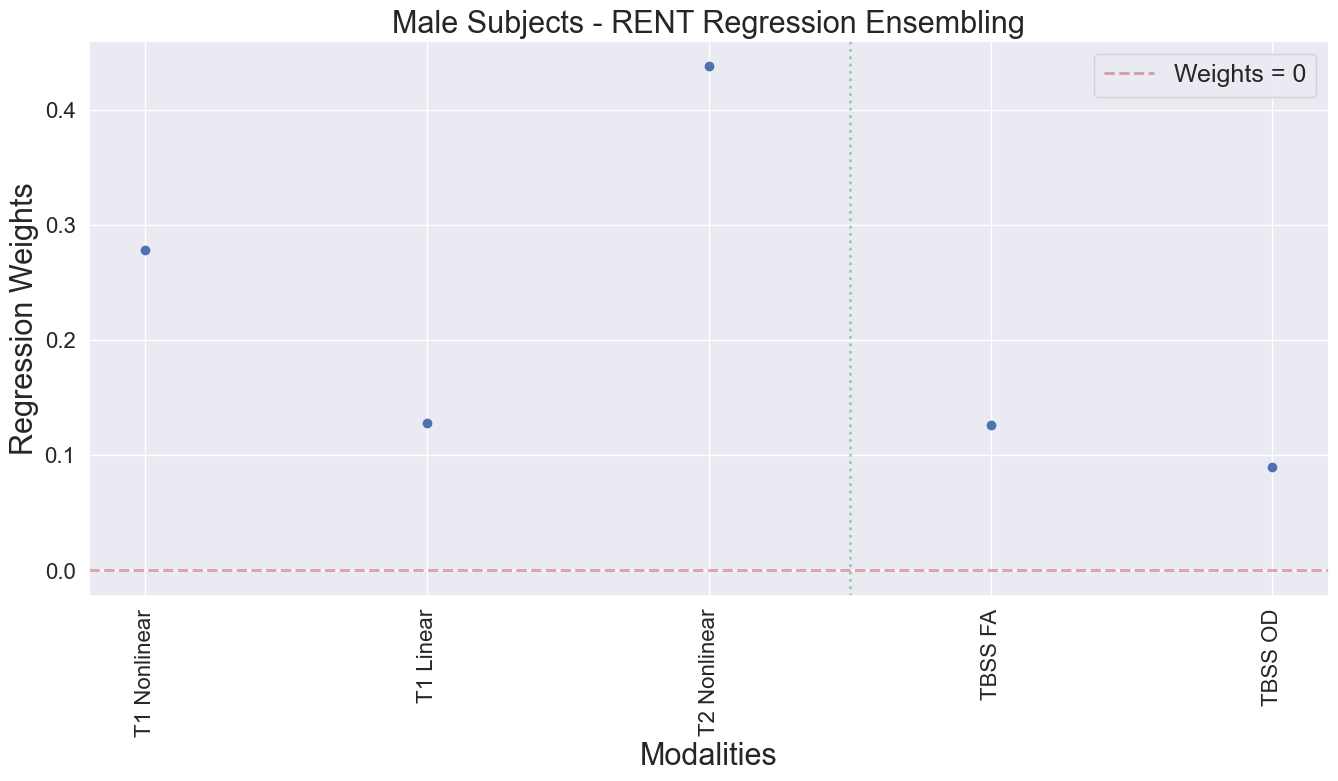

In [14]:
title_font_size=22
ticks_font_size=16
legend_font = 18
# figsize=(16, 9.6)

namesNN = [
    'T1 Nonlinear', 'T1 Linear', 'T2 Nonlinear', 'TBSS FA', 'TBSS OD',
]

fig = plt.figure(figsize=(16, 7.2))

plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), namesNN, rotation=90, fontsize= ticks_font_size);
plt.xlabel("Modalities", fontsize=title_font_size)
plt.yticks(fontsize=ticks_font_size)
plt.ylabel("Regression Weights", fontsize=title_font_size)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='Weights = 0');
plt.axvline(x=2.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
# plt.axvline(x=11.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
# plt.axvline(x=12.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
# plt.axvline(x=20.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);


plt.legend(loc=1, fontsize=legend_font)

plt.title('Male Subjects - RENT Regression Ensembling', fontsize=title_font_size)

fig.savefig('Male_RENT_weights.png', bbox_inches='tight')



